In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
pip install keras_preprocessing

In [113]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
import re
from os import listdir
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Dense,Conv1D,MaxPool1D,Flatten,Embedding
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [114]:
# load doc into memory
def load_doc(filename):
  file = open(filename, 'r')
  text = file.read()
  file.close()
  return text

In [115]:
# turn a doc into clean tokens
def clean_doc(doc):
  # split into tokens by white space
  tokens = doc.split()

  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))

  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]

  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]

  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]

  # filter out short tokens
  tokens = [word for word in tokens if len(word)>1]

  return tokens

In [116]:
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
  # load the doc
  doc = load_doc(filename)

  # clean the doc
  tokens = clean_doc(doc)

  # filter by vocab
  tokens = [w for w in tokens if w in vocab]

  return ' '.join(tokens)

In [117]:
# Load all docs in a directory
def process_docs(directory,is_train):
  documents = []
  for filename in listdir(directory):
    # skip all reviews in the test set
    if is_train and filename.startswith('cv9'):
      continue
    if not is_train and not filename.startswith('cv9'):
      continue
    path = directory + '/' + filename
    doc = load_doc(path)

    tokens = clean_doc(doc)
    documents.append(tokens)
  return documents

In [118]:
def load_clean_dataset(is_train):
  # load documents
  neg  = process_docs('/content/drive/MyDrive/review_polarity/txt_sentoken/neg',is_train)
  pos  = process_docs('/content/drive/MyDrive/review_polarity/txt_sentoken/pos',is_train)
  docs = neg + pos
  # prepare labels
  labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
  return docs, labels

In [119]:
train, train_labels = load_clean_dataset(True)
test, test_labels = load_clean_dataset(False)

In [120]:
# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer


In [121]:
# integer encode and pad documents
def encode_docs(tokenizer, max_length, docs):
  #integer encode
  encoded = tokenizer.texts_to_sequences(docs)
  # pad documents
  padded = pad_sequences(encoded, maxlen=max_length, padding='post')
  return padded

## Build the model

In [122]:
# define the model
def define_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 100, input_length=max_length))
  model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
  model.add(MaxPool1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile network
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize defined model
  model.summary()
  return model

In [123]:
train_docs, y_train = load_clean_dataset(True)
test_docs, y_test = load_clean_dataset(False)

In [124]:
# create tokenizer
tokenizer = create_tokenizer(train_docs)

In [125]:
# define vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 44277


In [126]:
# calculate the maximum sequence length
max_length = max([len(s) for s in train_docs])
print('Max Sequence Length: %d' % max_length)

Max Sequence Length: 1380


In [127]:
# encode data
X_train = encode_docs(tokenizer, max_length, train_docs)
X_test = encode_docs(tokenizer, max_length, test_docs)

In [128]:
X_train.shape, X_test.shape

((1810, 1380), (200, 1380))

In [129]:
X_train

array([[  818,  1971, 25868, ...,     0,     0,     0],
       [   89,   334,    97, ...,     0,     0,     0],
       [ 2228,   152,     3, ...,     0,     0,     0],
       ...,
       [10024,  8535, 13460, ...,     0,     0,     0],
       [  637,  9934,  2368, ...,     0,     0,     0],
       [ 1556,   125,  2444, ...,     0,     0,     0]], dtype=int32)

## Train the model

In [130]:
# fit the network
model = define_model(vocab_size, max_length)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1380, 100)         4427700   
                                                                 
 conv1d_3 (Conv1D)           (None, 1373, 32)          25632     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 686, 32)           0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 21952)             0         
                                                                 
 dense_6 (Dense)             (None, 10)                219530    
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                      

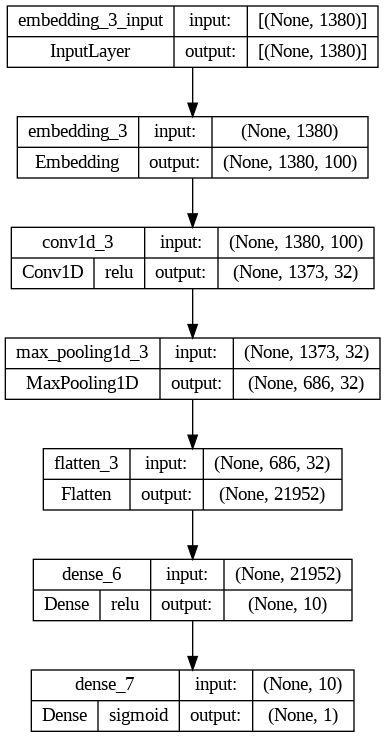

In [131]:
plot_model(model, show_layer_activations=True, show_shapes=True, show_layer_names=True)

In [132]:
model.fit(X_train, np.array(y_train), epochs=10,batch_size=10)

Epoch 1/10
181/181 [==============================] - 37s 195ms/step - loss: 0.6842 - accuracy: 0.5276
Epoch 2/10
181/181 [==============================] - 24s 134ms/step - loss: 0.2895 - accuracy: 0.8829
Epoch 3/10
181/181 [==============================] - 24s 132ms/step - loss: 0.0102 - accuracy: 0.9983
Epoch 4/10
181/181 [==============================] - 24s 133ms/step - loss: 0.0019 - accuracy: 0.9994
Epoch 5/10
181/181 [==============================] - 25s 138ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 6/10
181/181 [==============================] - 26s 144ms/step - loss: 5.9201e-04 - accuracy: 1.0000
Epoch 7/10
181/181 [==============================] - 24s 134ms/step - loss: 3.6362e-04 - accuracy: 1.0000
Epoch 8/10
181/181 [==============================] - 22s 124ms/step - loss: 2.4492e-04 - accuracy: 1.0000
Epoch 9/10
181/181 [==============================] - 24s 135ms/step - loss: 1.6812e-04 - accuracy: 1.0000
Epoch 10/10
181/181 [==============================] - 22

In [133]:
model.evaluate(X_test, np.array(y_test),batch_size=1)

200/200 [==============================] - 1s 4ms/step - loss: 0.4315 - accuracy: 0.8650


[0.4315016567707062, 0.8650000095367432]

In [142]:
# Test positive text
text1 = 'Best movie ever! It was great, I will definitely recommend it.'
text2 = 'This is a bad movie. Please dont watch it.'

In [143]:
# classify a review as negative or positive
def predict_sentiment(review):
  # clean the data
  tokens = clean_doc(review)
  # map tokens to ints
  line = ' '.join(tokens)
  encoded = encode_docs(tokenizer, max_length, [line])
  # predict sentiment
  yhat = model.predict(encoded)
  precent_pos = yhat[0,0]
  if round(precent_pos) == 0:
    return (1-precent_pos), 'NEGATIVE'
  return precent_pos, 'POSITIVE'

In [140]:
predict_sentiment(text1)

1/1 [==============================] - 0s 22ms/step


(0.53731769323349, 'NEGATIVE')

In [137]:
predict_sentiment(text2)

1/1 [==============================] - 0s 22ms/step


(0.6189910769462585, 'NEGATIVE')